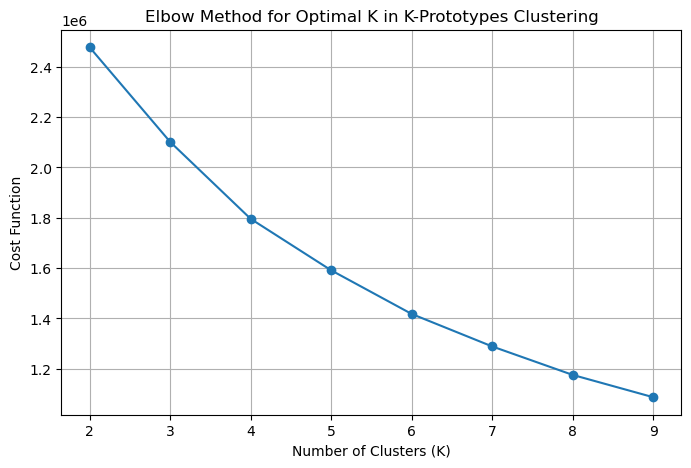

In [39]:
import warnings
warnings.filterwarnings('ignore')

from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
file_path = "shopping_behavior_updated.csv"
df = pd.read_csv(file_path)

# Use all available features
df_full = df.copy()
df_full.drop(['Customer ID'], axis=1, inplace=True)

# Identify categorical and numerical columns
categorical_cols = df_full.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_full.select_dtypes(include=['number']).columns.tolist()

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_full[col] = le.fit_transform(df_full[col])
    label_encoders[col] = le

# Convert dataframe to numpy array for KPrototypes
df_full_np = df_full.to_numpy()

# Determine the optimal number of clusters using the elbow method
costs = []
K_range = range(2, 10)
for k in K_range:
    kp = KPrototypes(n_clusters=k, init="Cao", n_init=5, verbose=0)
    clusters = kp.fit_predict(df_full_np, categorical=[df_full.columns.get_loc(col) 
                                                       for col in categorical_cols])
    costs.append(kp.cost_)

# Plot the cost function to find the optimal K
plt.figure(figsize=(8, 5))
plt.plot(K_range, costs, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Cost Function")
plt.title("Elbow Method for Optimal K in K-Prototypes Clustering")
plt.grid(True)
plt.show()



In [45]:
# Apply K-Prototypes clustering with optimal K (assume 4 for now, replace based on the plot)
optimal_k = 6
kprototypes_model = KPrototypes(n_clusters=optimal_k, init="Cao", n_init=5, verbose=0)
df_full["prod_cluster"] = kprototypes_model.fit_predict(df_full_np, categorical=[df_full.columns.get_loc(col) for col in categorical_cols])

# Decode cluster composition back to human-readable values
def decode_cluster(row):
    for col in categorical_cols:
        row[col] = label_encoders[col].inverse_transform([int(row[col])])[0]
    return row

cluster_composition = df_full.groupby("prod_cluster").apply(lambda x: x.mode().iloc[0]).apply(decode_cluster, axis=1)

# Investigate clustering results
cluster_counts = df_full["prod_cluster"].value_counts()
cluster_summary = df_full.groupby("prod_cluster").mean()


In [46]:
cluster_composition

,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases,prod_cluster
prod_cluster,,,,,,,,,,,,,,,,,,
0,28.0,Male,Blouse,Clothing,94.0,West Virginia,M,Green,Fall,4.4,No,Free Shipping,No,No,5.0,PayPal,Bi-Weekly,0.0
1,52.0,Male,Jewelry,Clothing,26.0,Maryland,M,Silver,Spring,3.5,No,Standard,No,No,40.0,PayPal,Monthly,1.0
2,25.0,Male,Shirt,Clothing,64.0,New Hampshire,M,White,Winter,3.4,No,Store Pickup,No,No,48.0,Credit Card,Quarterly,2.0
3,50.0,Male,Handbag,Clothing,51.0,Connecticut,M,Olive,Spring,2.6,No,Next Day Air,No,No,4.0,Cash,Annually,3.0
4,69.0,Male,Dress,Clothing,85.0,Louisiana,M,Violet,Fall,3.9,No,Free Shipping,No,No,38.0,Cash,Quarterly,4.0
5,27.0,Male,Socks,Clothing,23.0,Nebraska,M,Yellow,Summer,4.0,No,Free Shipping,No,No,6.0,Bank Transfer,Every 3 Months,5.0


1. Gender is kind of useless. I think it's because most of customers are male in this shopping mall.
2. Cluster 0, 1, 3, 4 are interesting. The mode for `Gender` is male, but mode for `Item Purchased` are items for women.
3. Cluster 0 and 4 are top spender. But they are distinctively different in many interesting ways.
4. We need to watch for cluster 3. Their `Review Rating` is pretty low.

In [50]:
cluster_counts

prod_cluster
4    696
5    689
1    662
0    631
2    625
3    597
Name: count, dtype: int64

They are evenly distributed.